In [1]:
import random 
import numpy as np 
import torch 
from utilities.pg_utils import set_seed
#set_seed(43)

In [2]:
# The purpose of this file is to create a price tensor for input into the neural network
# and to train the policy using Deep Deterministic Policy Gradient.
# Code is inspired by the paper "A Deep Reinforcement Learning Framework for the Financial Portfolio Management Problem"
# For more details, see: c.f https://arxiv.org/abs/1706.10059


from typing import List
import torch 
from ddpgportfolio.agent.ddpg_agent import DDPGAgent
from ddpgportfolio.dataset import KrakenDataSet
from ddpgportfolio.portfolio.portfolio import Portfolio

torch.set_default_device("mps")



BATCH_SIZE = 50  # training is done in mini-batches
WINDOW_SIZE = 50  # last n timesteps for the price tensor
STEP_SIZE = 1  # for rolling window batch sampler
start_date = "2024-01-01"  # start date of trading
end_date = "2024-09-30"
N_EPISODES = 150  # number of episodes to train the agent
N_ITERATIONS_PER_EPISODE = 20
# DEVICE = "mps"

asset_names: List[str] = [
    "CASH",
    "SOL",
    "ADA",
    "USDT",
    "AVAX",
    "LINK",
    "DOT",
    "PEPE",
    "ETH",
    "XRP",
    "TRX",
    "MATIC",
]

portfolio = Portfolio(asset_names=asset_names, start_date=start_date, end_date=end_date)
# kraken_ds = KrakenDataSet(portfolio, WINDOW_SIZE)
agent = DDPGAgent(portfolio, BATCH_SIZE, WINDOW_SIZE, STEP_SIZE, 100)

# need to pretrain the agent to populate the replay buffer with experiences
# train the agent


In [3]:

import numpy as np
import matplotlib.pyplot as plt
weights = []
kraken_ds = KrakenDataSet(portfolio, 50, 1)


In [4]:
# train agent
agent.train(5);

Training Started for DeepPG Agent


RuntimeError: you can only change requires_grad flags of leaf variables.

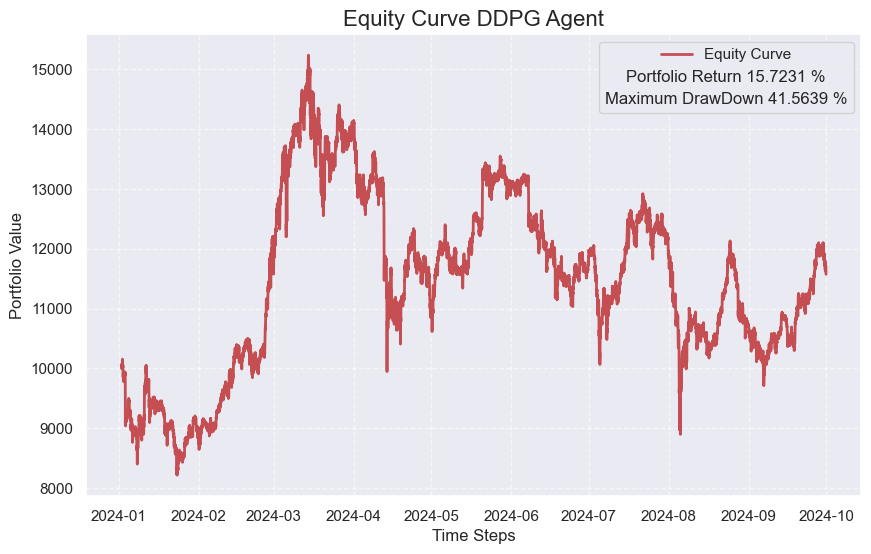

In [5]:
# checking pvm as it should be similar to buy and hold prior to training
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
weights = []
ds = KrakenDataSet(portfolio, 50, 1)
cl_price = portfolio.get_close_price()
dates = cl_price.index

sns.set_theme()
pf_previous = 10000
agent_equity_curve = [pf_previous]
total_reward = 0
weights = []



for i in range(len(ds) + 49):
    Xt, prev_index = ds[i]
    yt = 1 / Xt[0, :, -2]
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    wt = agent.pvm.get_memory_stack(prev_index + 1)
    wt_cash = 1 - wt.sum()
    wt = torch.concat([wt_cash.unsqueeze(0), wt], dim=-1)
    weights.append(wt)
    reward = torch.dot(wt, yt) 
    pf_current = pf_previous * reward
    agent_equity_curve.append(pf_current.item())
    pf_previous = pf_current

# Plot the equity curve
plt.figure(figsize=(10, 6))
plt.plot(dates[49:], agent_equity_curve, label="Equity Curve", linewidth=2, color='r')
plt.title("Equity Curve DDPG Agent", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)

final_return = agent.portfolio.calculate_final_equity_return(agent_equity_curve)
mdd = agent.portfolio.calculate_max_drawdown(agent_equity_curve)
#plt.legend(loc='best');
a = plt.legend(loc='best')
import matplotlib.offsetbox as offsetbox
txt=offsetbox.TextArea(f"Portfolio Return {final_return:.4f} %")
txt2=offsetbox.TextArea(f"Maximum DrawDown {mdd:.4f} %")
box = a._legend_box
box.get_children().append(txt)
box.get_children().append(txt2)
box.set_figure(box.figure)


In [6]:
agent.entropy_beta

np.float64(0.0)

In [5]:
agent.portfolio.calculate_final_equity_return(agent_equity_curve)

13.836494140625

In [7]:
agent.portfolio.calculate_max_drawdown(agent_equity_curve)

8.959866186836274

In [5]:
weights[-5:]

[tensor([0.1045, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814,
         0.0814, 0.0814, 0.0814], device='mps:0'),
 tensor([0.1044, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814,
         0.0814, 0.0814, 0.0814], device='mps:0'),
 tensor([0.1044, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814,
         0.0814, 0.0814, 0.0814], device='mps:0'),
 tensor([0.1045, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814, 0.0814,
         0.0814, 0.0814, 0.0814], device='mps:0'),
 tensor([0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833, 0.0833,
         0.0833, 0.0833, 0.0833], device='mps:0')]

In [15]:
agent.pvm.memory[13118:13120]

tensor([[0.0348, 0.0337, 0.0352, 0.0335, 0.0335, 0.0324, 0.0327, 0.0344, 0.0324,
         0.0358, 0.0331],
        [0.0358, 0.0346, 0.0364, 0.0346, 0.0347, 0.0335, 0.0329, 0.0357, 0.0342,
         0.0370, 0.0342]], device='mps:0')

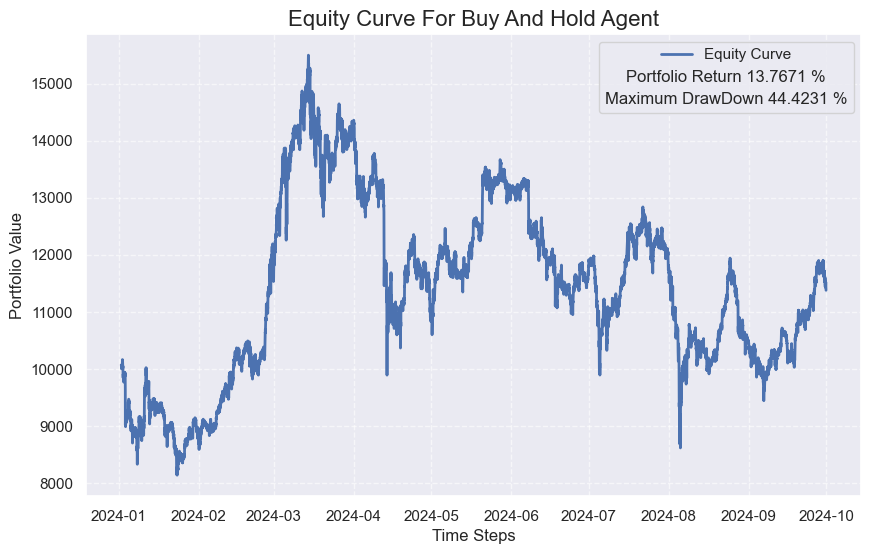

In [24]:
# buy and hold
buy_and_hold_weights = np.ones(12) / 12 # Equal allocation
buy_and_hold_equity = [10000]
pf_previous = 10000

for i in range(len(ds) + 49):
    Xt, _ = ds[i]
    yt = 1 / Xt[0, :, -2] # Price relatives
    yt = torch.concat([torch.ones(1), yt], dim=-1)
    reward = np.dot(buy_and_hold_weights, yt.cpu().numpy())  # No rebalancing
    pf_current = pf_previous * reward
    buy_and_hold_equity.append(pf_current)
    pf_previous = pf_current

cl_price = portfolio.get_close_price()
dates = cl_price.index
plt.figure(figsize=(10, 6))
plt.plot(dates[49:], buy_and_hold_equity, label="Equity Curve", linewidth=2)
plt.title("Equity Curve For Buy And Hold Agent", fontsize=16)
plt.xlabel("Time Steps", fontsize=12)
plt.ylabel("Portfolio Value", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
final_return = agent.portfolio.calculate_final_equity_return(buy_and_hold_equity)
mdd = agent.portfolio.calculate_max_drawdown(buy_and_hold_equity)
#plt.legend(loc='best');
a = plt.legend(loc='best')
import matplotlib.offsetbox as offsetbox
txt=offsetbox.TextArea(f"Portfolio Return {final_return:.4f} %")
txt2=offsetbox.TextArea(f"Maximum DrawDown {mdd:.4f} %")
box = a._legend_box
box.get_children().append(txt)
box.get_children().append(txt2)
box.set_figure(box.figure)


Reward Min: -0.0711669847369194, Reward Max: 0.06349028646945953
Reward Mean: -0.0004197242091987734, Reward Std: 0.0045933990880188125


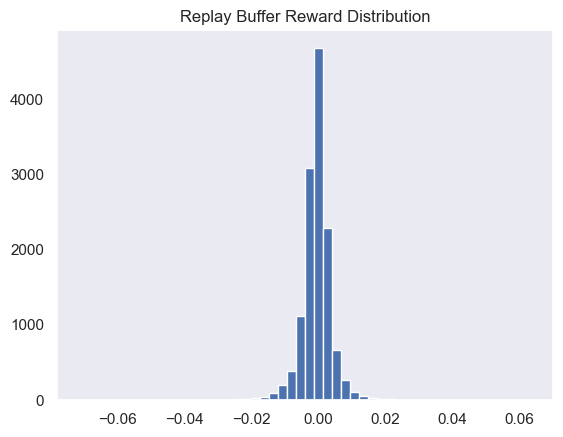

In [6]:
import matplotlib.pyplot as plt
rewards = [exp.reward for exp in agent.replay_memory.buffer]
print(f"Reward Min: {min(rewards)}, Reward Max: {max(rewards)}")
print(f"Reward Mean: {np.mean(rewards)}, Reward Std: {np.std(rewards)}")
plt.hist(rewards, bins=50)
plt.title("Replay Buffer Reward Distribution")

plt.grid()

In [7]:
sampled_actions = torch.stack([exp.action for exp in agent.replay_memory.buffer])
action_variances = torch.var(sampled_actions, dim=0)
print("Action Variance per Dimension:", action_variances)

Action Variance per Dimension: tensor([0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0011, 0.0010, 0.0011,
        0.0011, 0.0011], device='mps:0')


In [8]:
import pandas as pd
action_correlation = torch.corrcoef(sampled_actions.T)  # Correlation matrix
print("Action Correlation Matrix:", pd.DataFrame(action_correlation.cpu().numpy()))

Action Correlation Matrix:           0         1         2         3         4         5         6   \
0   1.000000 -0.084143 -0.083400 -0.108323 -0.089635 -0.094153 -0.096855   
1  -0.084143  1.000000 -0.094477 -0.068351 -0.096227 -0.097336 -0.078808   
2  -0.083400 -0.094477  1.000000 -0.053231 -0.077583 -0.126307 -0.098500   
3  -0.108323 -0.068351 -0.053231  1.000000 -0.096766 -0.090808 -0.091241   
4  -0.089635 -0.096227 -0.077583 -0.096766  1.000000 -0.097567 -0.094192   
5  -0.094153 -0.097336 -0.126307 -0.090808 -0.097567  1.000000 -0.089522   
6  -0.096855 -0.078808 -0.098500 -0.091241 -0.094192 -0.089522  1.000000   
7  -0.082767 -0.102626 -0.076428 -0.090668 -0.082095 -0.075594 -0.103226   
8  -0.084986 -0.109262 -0.109689 -0.102733 -0.066047 -0.088487 -0.088737   
9  -0.116269 -0.076139 -0.122686 -0.109022 -0.092933 -0.091630 -0.058082   
10 -0.076533 -0.094713 -0.074206 -0.098494 -0.082556 -0.087293 -0.097918   

          7         8         9         10  
0  -0.082767 -0

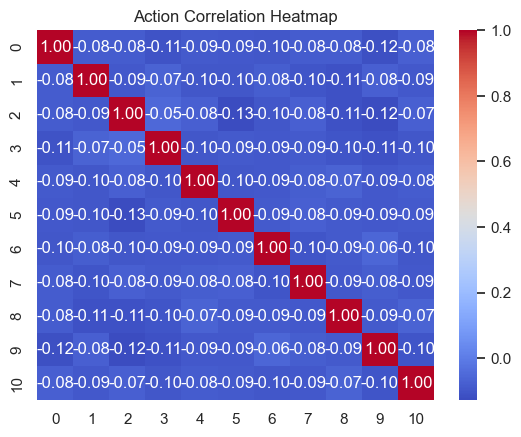

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(action_correlation.cpu().numpy(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Action Correlation Heatmap")
plt.show()

In [10]:
import scipy.stats
entropy = [scipy.stats.entropy(sampled_actions[:, i].cpu().numpy()) for i in range(11)]
print("Entropy per Weight:", entropy)

Entropy per Weight: [np.float64(9.388982910810324), np.float64(9.38894287918392), np.float64(9.391169247353085), np.float64(9.388640917418446), np.float64(9.390416823292357), np.float64(9.389275053285548), np.float64(9.389467728343991), np.float64(9.393956626405359), np.float64(9.389406313827529), np.float64(9.389445051599875), np.float64(9.39253504792901)]


In [11]:
from scipy.spatial.distance import pdist, squareform
pairwise_distances = pdist(sampled_actions.cpu().numpy())
mean_distance = np.mean(pairwise_distances)
print("Mean Pairwise Distance:", mean_distance)

Mean Pairwise Distance: 0.13429267570978165


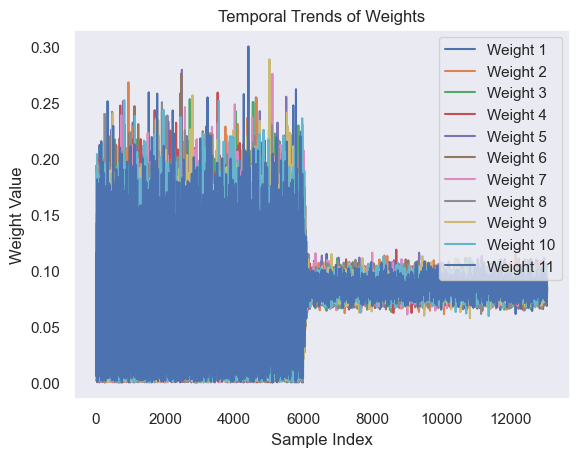

In [12]:
plt.grid();
for i in range(11):
    plt.plot(sampled_actions[:, i].cpu().numpy(), label=f"Weight {i+1}")
plt.title("Temporal Trends of Weights")
plt.xlabel("Sample Index")
plt.ylabel("Weight Value")
plt.legend()
plt.show()

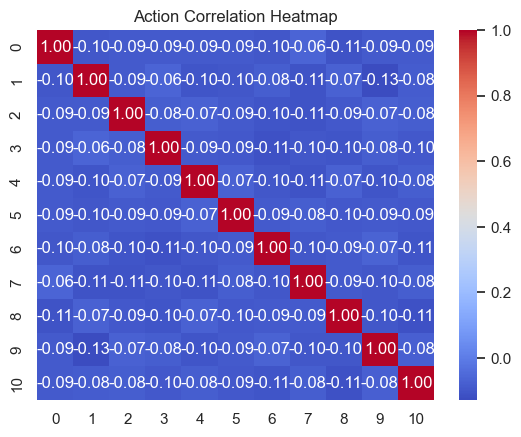

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(action_correlation.cpu().numpy(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Action Correlation Heatmap")
plt.show()

In [17]:
action_means = torch.mean(sampled_actions, dim=0)
action_ranges = torch.max(sampled_actions, dim=0).values - torch.min(sampled_actions, dim=0).values
print("Action Means:", action_means)
print("Action Ranges:", action_ranges)

Action Means: tensor([0.0836, 0.0835, 0.0842, 0.0835, 0.0834, 0.0842, 0.0837, 0.0842, 0.0836,
        0.0839, 0.0836], device='mps:0')
Action Ranges: tensor([0.2971, 0.2691, 0.2662, 0.3959, 0.3134, 0.2677, 0.6609, 0.4279, 0.3774,
        0.3262, 0.6333], device='mps:0')


In [8]:
from torch.utils.data import DataLoader

dataloader = DataLoader(
    kraken_ds,
    batch_size=50,
    pin_memory=True,
    generator=torch.Generator(device='mps'),
    )

In [9]:
for Xt, prev_index in dataloader:
    pass

In [11]:
prev_index

tensor([13048, 13049, 13050, 13051, 13052, 13053, 13054, 13055, 13056, 13057,
        13058, 13059, 13060, 13061, 13062, 13063, 13064, 13065, 13066, 13067,
        13068, 13069, 13070], device='mps:0')